# Ocean Data
Provided by Phoebe Lam and Matthew Marcus

In [1]:
from importlib import reload
import itertools
from ipywidgets import *

import re
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation, PillowWriter
import mplcursors
from matplotlib import gridspec

import scipy
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import umap

## Data I/O

In [2]:
def get_data_from_directory(directory, energy, comments=False):
    """Get all data (.e) files in listed directory."""
    
    datafiles = os.listdir(directory)
    filenames = [filename for filename in datafiles if filename.endswith('e')]
    if comments == False:
        Raw_data = {filename: np.loadtxt(f'{directory}{filename}').T for filename in filenames}
    else:
        Raw_data = {}
        for filename in filenames:
            data = []
            with open(f'{directory}{filename}') as f:
                for line in f:
                    if (not line.startswith('#')) and (not line.startswith('=')) and line != '\n':
                        parsed = line.replace('\t', ' ').replace('\n','').replace('E', 'e').split(' ')
                        try:
                            parsed = [float(e) for e in parsed] 
                            data.append(parsed)
                        except:
                            print(f"Can't parse '{line}' in file {filename}")                        
            f.close()
            data = np.array(data)
            Raw_data[filename] = data.T
    
    min_e = np.inf
    max_e = -np.inf
    for x, y in list(Raw_data.values()):
        minx = min(x)
        maxx = max(x)
        if minx < min_e:
            min_e = minx
        if maxx > max_e:
            max_e = maxx
    for x, y in list(Raw_data.values()):
        minx = min(x)
        maxx = max(x)
        if minx > min_e:
            min_e = minx
        if maxx < max_e:
            max_e = maxx
    #print(min_e, max_e)
    
    Data = {}
    for file, spectrum in Raw_data.items():
        x, y = spectrum
        interperlator = interp1d(x, y)
        interpolated_y = interperlator(energy)
        Data[file] = np.array([energy, interpolated_y])
    DATA = np.array(list(Data.values()))
    print(DATA.shape)
    
    return Data, DATA

In [3]:
energy = np.linspace(7081, 7325, 244 * 2 + 1)
X1_dict, X1 = get_data_from_directory('Data/XANES1/', energy)
X2_dict, X2 = get_data_from_directory('Data/XANES2/', energy)
Ref_Data_dict, REF_DATA = get_data_from_directory('References/', energy, comments=True)

XANES1 = X1[:, 1, :]
XANES2 = X2[:, 1, :]
Refs = REF_DATA[:, 1, :]

(214, 2, 489)
(126, 2, 489)
(65, 2, 489)


In [22]:
# todo -- how good are these references at describing exp? PCA proj onto each other's spaces?

## Visualizing data through animations

In [8]:
def plot_spectra(i, X_dict):
    fig, ax = plt.subplots(figsize=(6, 4))    
    filename, spectrum = list(X_dict.items())[i]
    x, y = spectrum
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab10(1), label=filename.replace('.e', ''))
    ax.text(7050, 1.85, filename.replace('.e', ''), fontsize=16)
    ax.set_yticks([])
    ax.tick_params(direction='in', axis='x', width=1, length=8, which='major', labelsize=16)
    ax.set_xlim(7040, 7335)
    ax.set_ylim(-0.1, 2.0)
        
slider = IntSlider(min=0, max=len(X2) - 1, step=1, value=0,
                   layout=widgets.Layout(width='50%'))

interactive(plot_spectra, i=slider, X_dict=fixed(X1_dict))

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='50%'), max=125), Output()), _do…

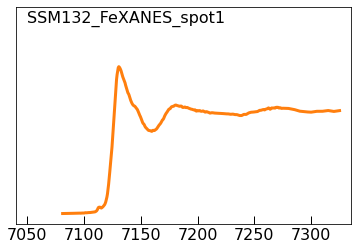

In [27]:
def animate(i):
    ax.clear()
    filename, spectrum = list(X2_dict.items())[i]
    x, y = spectrum
    ax.plot(x, y, '-', linewidth=3, c=plt.cm.tab10(1), label=filename.replace('.e', ''))
    ax.text(7050, 1.85, filename.replace('.e', ''), fontsize=16)
    ax.set_yticks([])
    ax.tick_params(direction='in', axis='x', width=1, length=8, which='major', labelsize=16)
    ax.set_xlim(7040, 7335)
    ax.set_ylim(-0.1, 2.0)
        
fig, ax = plt.subplots(figsize=(6, 4))
ani = FuncAnimation(fig, animate, interval=5, frames=100, blit=False)    
ani.save("Figures/XANES2.gif", dpi=800, writer=PillowWriter(fps=3.5))

# Dimensionality Reduction

In [28]:
def make_scree_plot(data, n=5, threshold=0.95, show_first_PC=True, mod=0):
    fig, ax = plt.subplots(figsize=(8,6))
    pca = PCA()
    pca_components = pca.fit_transform(data)

    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]

    ax.plot(x, cdf, 's-', markersize=10, fillstyle='none',
            color=plt.cm.tab10(.15))
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

    if show_first_PC:
        PC1 = pca.components_[0]
        plt.plot(np.linspace(1, n, len(PC1)), -PC1*0.3 + min(cdf) + 0.05, 'k', linewidth=2)
        text = ax.text(n - 1, min(cdf) + 0.06, '$PC_1$', ha="right", va="bottom", size=20)

    if mod == 0:
        xticks = np.arange(n) + 1
    else:
        xticks = np.arange(0, n + 1, mod)
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(min(cdf) - 0.05, 1.02)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)

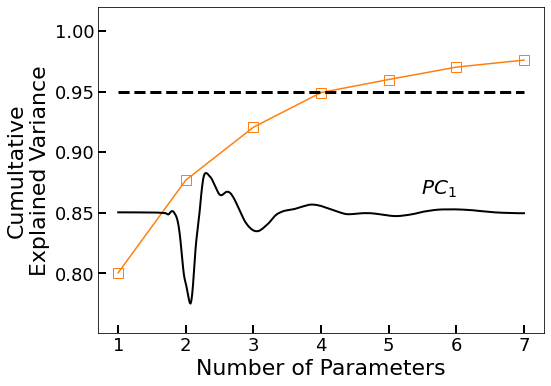

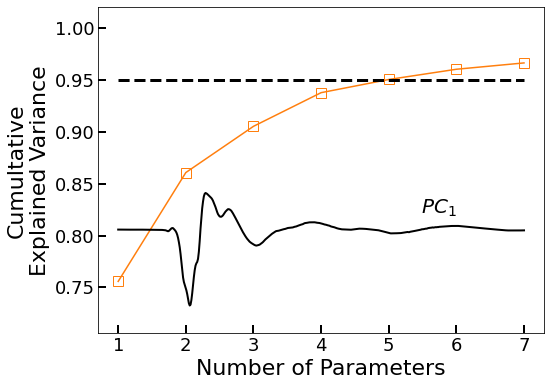

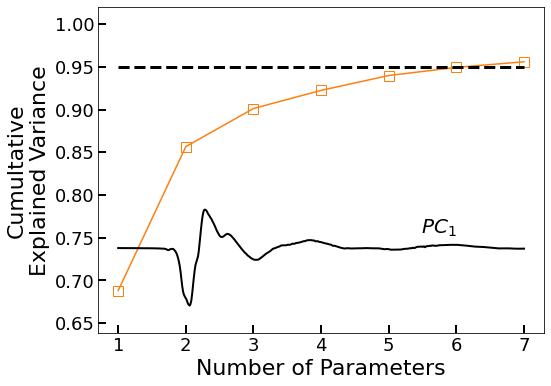

In [29]:
make_scree_plot(Refs, n=7)
make_scree_plot(XANES1, n=7)
make_scree_plot(XANES2, n=7)

## Instead of K-means clustering on 6D PCA, we're going to use dbscan clusters on 2D UMAP

In [50]:
NUM = 2
if NUM == 1:
    DATA = XANES1
    DICT = X1_dict
else:
    DATA = XANES2
    DICT = X2_dict

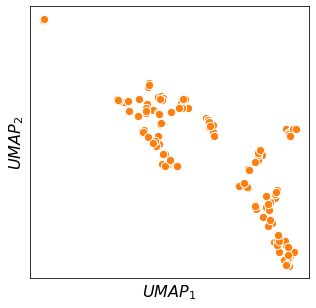

In [51]:
pca = PCA(n_components=10)
pca_components = pca.fit_transform(DATA)

n_neighbors = 5
min_dist = 0.09
reducer = umap.UMAP(random_state=42, n_components=2,
                    n_neighbors=n_neighbors, min_dist=min_dist)
reduced_space = reducer.fit_transform(pca_components)

fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=70, 
            color=plt.cm.tab20(2), edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$UMAP_1$', fontsize=16)
ax.set_ylabel('$UMAP_2$', fontsize=16)
plt.show()

In [52]:
def add_point_label(pickable, dictionary):
    """Add point label."""
    def onselect(sel):
        label = list(dictionary.keys())[sel.target.index].replace(".e", '')
        sel.annotation.set_text(label)
    mplcursors.cursor(pickable, highlight=True).connect("add", onselect)

In [53]:
%matplotlib inline

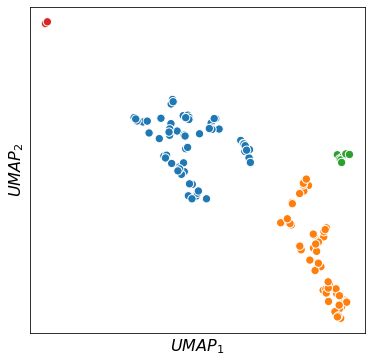

In [54]:
dbscan_clustering = DBSCAN(eps=1.3, min_samples=1).fit(reduced_space)
colors = [plt.cm.tab10(label) for label in dbscan_clustering.labels_]

fig, ax = plt.subplots(figsize=(6, 6))
points = ax.scatter(reduced_space[:, 0], reduced_space[:, 1], marker='o', s=70, 
                     color=colors, edgecolor='w')
plt.xticks([])
plt.yticks([])
ax.set_xlabel('$UMAP_1$', fontsize=16)
ax.set_ylabel('$UMAP_2$', fontsize=16)

add_point_label(points, DICT)

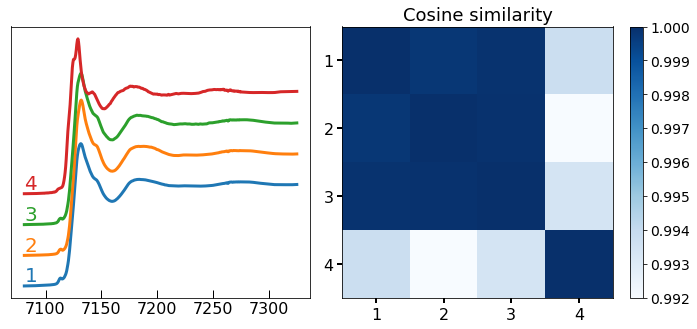

In [55]:
fig = plt.figure(figsize=(12, 5))
spec = fig.add_gridspec(ncols=2, width_ratios=[0.47, 0.53])
plt.subplots_adjust(wspace=0.1)

ax = fig.add_subplot(spec[0])
cluster_avgs = []
total_labels = np.unique(dbscan_clustering.labels_)
for label in total_labels:
    spectra = np.array([DATA[i] for i, l in enumerate(dbscan_clustering.labels_) if l == label])
    ax.plot(energy, np.average(spectra, axis=0) + label * 0.3, '-', linewidth=3, c=plt.cm.tab10(label))
    cluster_avgs.append(np.average(spectra, axis=0))
    ax.text(7081, label * 0.3 + 0.05, label + 1, c=plt.cm.tab10(label), fontsize=20)
cluster_avgs = np.array(cluster_avgs)
ax.set_yticks([])
ax.tick_params(direction='in', axis='x', width=1, length=8, which='major', labelsize=16)

ax = fig.add_subplot(spec[1])
N = len(total_labels)
mod = 1
Similarity_matrix = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    if i <= j:
        score = cosine_similarity([cluster_avgs[i]], [cluster_avgs[j]])
        Similarity_matrix[i, j] = score
        Similarity_matrix[j, i] = score
        
img = ax.imshow(Similarity_matrix, cmap='Blues', interpolation='nearest', aspect='auto')
ax.set_title('Cosine similarity', fontsize=18)
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=14)
ax.set_yticks(np.arange(0, N, mod))
ax.set_xticks(np.arange(0, N, mod))
ax.set_yticklabels(np.arange(1, N + 1, mod))
ax.set_xticklabels(np.arange(1, N + 1, mod))
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=16)

plt.show()

Here, they LCF onto Fe refs of these cluster averages to get the general makeup of each cluster, and justify it by saying that the LCF fits to each reference generally agree, with the most prevalent components appearing in the cluster averaged fit. (vs LCF each spectrum indivually and then coming up with cluster statisitics)

# Are the clusters real? A look at $diversity$ (maximizing variance across each cluster)

In [56]:
total_avg = np.average(cluster_avgs, axis=0)
diversity = np.sum((cluster_avgs - total_avg)**2) / np.sum(total_avg)
print("Diversity of UMAP clusters:")
print(diversity)

cluster_sizes = []
for label in total_labels:
    count = np.sum([1 for i, l in enumerate(dbscan_clustering.labels_) if l == label])
    cluster_sizes.append(count)
cluster_sizes = np.array(cluster_sizes)

random_diversities = []
for k in range(1000):
    print(k, end='\r')
    Is = []
    indices = list(np.arange(np.sum(cluster_sizes)))
    for cluster in cluster_sizes:
        selection = np.random.choice(indices, size=cluster, replace=False)
        Is.append(selection)
        indices = [i for i in indices if i not in selection]

    cluster_avgs_random = []
    for j, label in enumerate(total_labels):
        spectra = np.array([DATA[i] for i in Is[j]])
        cluster_avgs_random.append(np.average(spectra, axis=0))
    cluster_avgs_random = np.array(cluster_avgs_random)

    total_avg_random = np.average(cluster_avgs_random, axis=0)
    diversity_random = np.sum((cluster_avgs_random - total_avg_random)**2) / np.sum(total_avg_random)
    random_diversities.append(diversity_random)
random_diversities = np.array(random_diversities)

print("\nDiversity of random clusters:")
xbar = np.average(random_diversities)
s = np.std(random_diversities)
print(f'{xbar} +/- {s}')  # sample mean and std

Diversity of UMAP clusters:
0.010883309551049202
999
Diversity of random clusters:
0.0002841498087853437 +/- 0.0002785181106943444


H0: Diversity from UMAP *is not* statistically significant compared to random groupings.

H1: Diversity from UMAP *is* statistically significant compared to random groupings.

We will be doing a z test with significance ($\alpha$) = 0.01

In [57]:
z = (diversity - xbar) / s
pval = scipy.stats.norm.sf(z)
print(pval)
alpha = 0.01
if pval < alpha:
    print("We reject the null hypothesis, so the diversity of the UMAP clusters is statisitcally significant.")
else:
    print("We cannot reject the null hypothesis, so the diversity of the UMAAP clusters " +
          "is not statisitcally significant.")

0.0
We reject the null hypothesis, so the diversity of the UMAP clusters is statisitcally significant.


Here they fit the spectra from one group onto the PCs of the other, and vice versa to see the overlap.

Alot of discussion relied on the LCF of the clusters to refs... I need those refs


Other possible analysis:
1. Cluster both groups together and see if they is separation within UMAP

Check size (from filter) of particles --> bulk like? (nanophase might not be like refs)

Potentially couple of points in pre-edge (but not in flourenscene mode) and int normal 10 eV past edge
Raw spectra (to test background normalization)

Standard backgrround subtraction in Athena

Measure full spectra in subset of data to train subset energies

# LCF

In [38]:
def chi_square(data, fit, sigma_squared=1):
    return np.sum((data - fit)**2 / sigma_squared)

def reduced_chi_square(data, fit, m, sigma_squared=1):
    dof = len(data) - m - 1
    return chi_square(data, fit, sigma_squared=sigma_squared) / dof
    
def R_score(data, fit):
    return np.sum((data - fit)**2) / np.sum(data**2)

def scale_coeffs_to_add_to_one(coeff_mtx):
    sums = [np.sum(coeffs) for coeffs in coeff_mtx]
    normalized_coeffs = np.array([coeff_mtx[i] / sums[i] for i in range(len(sums))])
    return normalized_coeffs

def objective_function(coeffs, Refs, target, lambda1, lambda2):
    calc = Refs.T @ coeffs
    calc = calc - np.min(calc)  # set min to zero
    return np.sum((calc - target)**2) \
           + lambda1 * np.sum(np.abs(coeffs)) \
           + lambda2 * (np.sum(coeffs) - 1)**2

def get_coeffs_from_spectra(spectra, Refs, lambda1=0, lambda2=1e8):
    m = Refs.shape[0]
    coeffs_0 = np.ones(m) / m
    bounds = np.zeros((m, 2))
    bounds[:, 1] = 1
    results = [minimize(objective_function, coeffs_0,
               args=(Refs, spectrum, lambda1, lambda2),
               bounds=bounds) for spectrum in spectra]
    coeffs = np.array([results[i].x for i in range(len(results))])
    return scale_coeffs_to_add_to_one(coeffs)

def get_sets_from_subset_indices(subset_indices, basis):
    subset = np.array([ele for i, ele in enumerate(basis) if i in subset_indices])
    non_subset_indices = np.array([i for i, ele in enumerate(basis) if i not in subset_indices])
    non_subset = np.array([ele for i, ele in enumerate(basis) if i not in subset_indices])
    return subset, non_subset_indices, non_subset

def get_goodness_of_fit_from_subset(subset, target, lambda1=0.1, lambda2=1e8):
    coeffs_hat = get_coeffs_from_spectra([target], subset, lambda1=lambda1, lambda2=lambda2)
    recon = coeffs_hat @ subset
    recon = recon.reshape(-1)
    recon = recon - np.min(recon)
    score = chi_square(target, recon)
    return score

def LCF(target, basis, subset_size, eps=1e-4, lambda1=0.1, lambda2=1e8):
    
    indices = np.arange(basis.shape[0])     
    best_score = np.inf
    best_subset_indices = np.zeros(subset_size)
    
    i = 0
    for subset_indices in itertools.combinations(indices, subset_size):
        print(i + 1, end='\r')
        subset_indices = np.array(subset_indices)
        subset, non_subset_indices, non_subset = get_sets_from_subset_indices(subset_indices, basis) 
        set_tuple = (subset, subset_indices, non_subset, non_subset_indices)
        score = get_goodness_of_fit_from_subset(subset, target, lambda1=lambda1, lambda2=lambda2)
        if score < best_score:
            best_score = score.copy()
            best_subset_indices = subset_indices.copy()
            if best_score < eps:
                break
        i += 1            
        subset_indices = best_subset_indices
        subset, _, _ = get_sets_from_subset_indices(subset_indices, basis)
    
    print(subset_indices, best_score)
    coeffs_hat = get_coeffs_from_spectra([target], subset, lambda1=lambda1, lambda2=lambda2)
    return subset_indices, subset, coeffs_hat, best_score

In [35]:
m = 65
subset_size = 2
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = Refs[:m] 
for i in range(m):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], targets, subset_size, lambda1=10, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scores.append(score)

[ 0 50] 0.0065303247591327745
[1 6] 0.0004224131398940841
[ 2 21] 0.04736211959776498
[2 4] 0.029168464621017912
[ 4 21] 0.005972230050633983
[ 5 10] 0.011434649465288722
[ 6 37] 0.00921981603773593
[ 7 10] 0.004856983541745923
[ 8 10] 0.0032282697559164377
[ 9 10] 0.004519760875830643
[ 0 10] 0.0022225224796133796
[10 11] 0.01661758809881364
[10 12] 0.005587393312502933
[10 13] 0.002514050349356985
[10 14] 0.0010464027979329698
[10 15] 0.006784436675258345
[10 16] 0.0038426546975242138
[17 21] 0.0027873165834745384
[18 19] 0.02281719394982499
[ 1 19] 0.0053363706518036215
[20 21] 0.0024287669673030317
[20 21] 0.0007161998984198689
[21 22] 0.0023242343132892115
[10 23] 0.00864940966794315
[24 56] 0.019004985633353795
[10 25] 0.012814147370505315
[10 26] 0.001694022434235427
[10 27] 0.008799481784857573
[ 5 28] 0.0065118786148409
[20 29] 0.001123826183323588
[21 30] 0.0032328850761788397
[10 31] 0.006387044224185734
[10 32] 0.006038482961379943
[ 7 33] 0.017733847208138517
[10 34] 0.013

Flagging these references:
1. Al192 Fe008.e
2. feroxyhite_trans_FeEXAFS_fl_OA.e
3. Ferrosmectite_Borch FeEXAFS.e

In [39]:
def label_ax_with_score(ax, target, pred, sub_idxs, conc, flag=False):
    R = R_score(target, pred)
    chi2 = chi_square(target, pred)
    xs = ax.get_xlim()
    ys = ax.get_ylim()
    label = '$C_{max} = ' + f'{sub_idxs}' + '_{(' + f'{int(conc * 100)}' + '\%)}$\n' \
            + '$\chi^2 = $' + f'{chi2:.03f}'
    if flag:
        c = 'red'
    else:
        c = 'k'
    ax.text(0.36 * (xs[1] - xs[0]) + xs[0], 0.12 * (ys[1] - ys[0]) + ys[0], label, 
            fontsize=16, color=c)
    
def plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Ref_Data_dict,
                    confidence=0.8, ncols=5, flag_identity=True):
    m = len(targets)
    preds = []
    for i in range(m):
        pred = coeffs[i] @ subsets[i]
        pred = pred - np.min(pred)
        preds.append(pred.reshape(-1))
    preds = np.array(preds) 
    
    if m % ncols == 0:
        nrows = int(m // ncols)
    else:
        nrows = int(m // ncols) + 1
    fig, axes = plt.subplots(figsize=(3.3 * ncols, 2.3 * nrows), ncols=ncols, nrows=nrows)
    plt.subplots_adjust(wspace=0, hspace=0)

    if len(axes.shape) == 2:
        for i in range(axes.shape[0]):            
            for j in range(axes.shape[1]):
                ax = axes[i, j]
                if i * ncols + j < m:
                    ax.plot(energy, targets[i * ncols + j], '-', linewidth=3, label='target')
                    ax.plot(energy, preds[i * ncols + j], '--', linewidth=3, label='fit')
                    max_i = subset_indices[i * ncols + j][np.argmax(coeffs[i * ncols + j])]
                    max_conc = np.max(coeffs[i * ncols + j])
                    if (max_i != i * ncols + j or max_conc < confidence) and flag_identity:
                        flag = True
                        print(list(Ref_Data_dict.keys())[i * ncols + j])
                    else:
                        flag = False
                    label_ax_with_score(ax, targets[i * ncols + j], preds[i * ncols + j],
                                        max_i + 1, max_conc, flag=flag)
                    if (i * ncols + j + 1) % (ncols) == 0:
                        ax.legend(fontsize=16, bbox_to_anchor=(1, 0.5), loc='center left')
                    ax.set_yticks([])
                    ax.set_xticks([])
                else:
                    ax.axis('off')
    else:
        for i, ax in enumerate(axes):
            if i < m:
                ax.plot(energy, targets[i], linewidth=3, label='target')
                ax.plot(energy, preds[i], linewidth=3, label='fit')
                ax.set_yticks([])
                ax.set_xticks([])
                max_i = subset_indices[i][np.argmax(coeffs[i])]
                max_conc = np.max(coeffs[i])
                if (max_i != i or max_conc < confidence) and flag_identity:
                    flag = True
                    print(list(Ref_Data_dict.keys())[i])
                else:
                    flag = False
                label_ax_with_score(ax, targets[i], preds[i],
                                    max_i + 1, max_conc, flag=flag)
                if i == m - 1:
                    ax.legend(fontsize=16, bbox_to_anchor=(1, 0.5), loc='center left')
            else:
                ax.axis('off')

In [ ]:
plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Ref_Data_dict)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.savefig('Figures/LCF_of_Refs_onto_themselves.png', dpi=800, bbox_inches='tight')

# LCF of Data onto Refs

[0 2 3] 0.016369276856867135
[0 1 3] 0.012975386726211667
[0 2 3] 0.016218637391376654
[0 1 3] 0.026078532220169016
Aegirine FeXANES powder avg.e


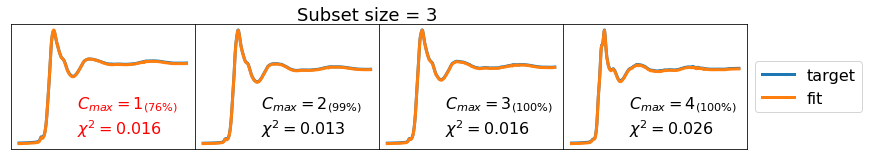

In [58]:
subset_size = 3
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = cluster_avgs
for i in range(len(targets)):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], targets, subset_size, lambda1=10, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scores.append(score)

plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Ref_Data_dict,
                ncols=len(cluster_avgs))              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.savefig(f'Figures/LCF_of_XANES{NUM}_cluster_avgs_onto_themselves.png', dpi=800, bbox_inches='tight')

In [59]:
subset_size = 3
subset_indices, subsets, scales, coeffs, scores = [], [], [], [], []
targets = cluster_avgs
for i in range(len(targets)):
    sub_idxs, subset, coeffs_hat, score = LCF(targets[i], Refs, subset_size, lambda1=10, lambda2=1e8)
    subset_indices.append(sub_idxs)
    subsets.append(subset)
    coeffs.append(coeffs_hat)
    scores.append(score)

[ 1  7 22] 0.013342396967609195
[10 21 52] 0.04542231530061795
[10 21 52] 0.03487854634265443
[ 8 10 33] 0.03332206545992463


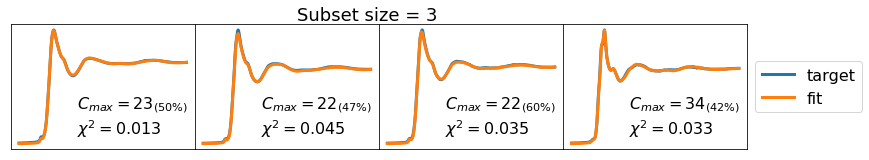

In [60]:
plot_recon_grid(energy, targets, subset_indices, subsets, coeffs, Ref_Data_dict,
                ncols=len(cluster_avgs), flag_identity=False)              
plt.suptitle(f'Subset size = {subset_size}', fontsize=18, y=.88, va='bottom')
plt.savefig(f'Figures/LCF_of_XANES{NUM}_cluster_avgs_onto_Refs.png', dpi=800, bbox_inches='tight')

In [61]:
coeffs = np.array(coeffs).reshape(len(targets), -1)
for i in range(len(targets)):
    print(f"Cluster {i + 1} ({cluster_sizes[i]}):")
    for j in range(subset_size):
        idx = subset_indices[i][j]
        conc = coeffs[i][j]
        name = list(Ref_Data_dict.keys())[idx].replace('.e', '')
        print(f'{name}: {conc * 100:.2f}%')
    print()

Cluster 1 (63):
Akaganeite_Chan FeXANES: 37.10%
AT11 Glass_Toner FeEXAFS: 12.37%
Ferrihydrite_6L_borch_trunc: 50.53%

Cluster 2 (51):
Biotite_ETH_oa: 6.46%
Ferrihydrite 2L_Kim FeXANES: 47.46%
Na-Montmorillionite_SWY-2_MAM: 46.08%

Cluster 3 (8):
Biotite_ETH_oa: 11.69%
Ferrihydrite 2L_Kim FeXANES: 60.64%
Na-Montmorillionite_SWY-2_MAM: 27.67%

Cluster 4 (4):
Augite CVF1_NHM FeXANES powder avg: 25.23%
Biotite_ETH_oa: 32.15%
GRSO4_synth_Borch FeEXAFS overabs: 42.62%

